# Vevina (Ziwei) Liu, Iteration 4 for INFOSYS 722

## package used

findspark pyspark matplotlib numpy pandas

# STEP 3: DATA PREPARATION

In [1]:
import matplotlib as plt
import numpy as np

In [2]:
# import dataset
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
from pyspark import SparkContext

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import *
spark = SparkSession.builder.appName('step_4to8').getOrCreate()
df = spark.read.csv('/home/ubuntu/Iteration_4-Vevina_Liu/loanITERATION4.csv',header=True,inferSchema=True)

In [4]:
print(df.columns)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il

## 3.1 Select the Data

### Remove loan status that are irrelavant to the model

In [3]:
# remove observations with loan_status == Does not meet the credit policy because no explanation about the types
df = df[(df['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid') & (df['loan_status'] != 'Does not meet the credit policy. Status:Charged Off')]
# remove observations with loan_status == Current and Issued
df = df[(df['loan_status'] != 'Current') & (df['loan_status'] != 'Issued')]
print('No. of Observations: ', df.count())

No. of Observations:  274390


### Remove attributes with more than 600,000 missing values

In [4]:
col_drop = ['inq_fi', 'total_cu_tl', 'inq_last_12m', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'] 
df = df.drop(*col_drop)
col_drop = ['il_util', 'open_rv_12m', 'open_rv_24m' 'max_bal_bc', 'all_util', 'dti_joint', 'verification_status_joint', 'annual_inc_joint']
df = df.drop(*col_drop)
col_drop = ['desc','mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog']
df = df.drop(*col_drop)
col_drop = ['policy_code', 'initial_list_status', 'zip_code', 'title', 'id', 'member_id', 'url', 'pymnt_plan', 'emp_title','earliest_cr_line', 'mths_since_last_record']
df = df.drop(*col_drop)
print('No. of Observations: ', df.count())
print('No. of Attributes: ' + str(len(df.columns)))

No. of Observations:  274390
No. of Attributes: 44


## 3.2 Clean the Data

In [5]:
from pyspark.sql.functions import mean
for i in df.dtypes:
    if i[1] != 'string':
        fillmean = df.select(mean(i[0])).collect()[0][0]
        df = df.na.fill(fillmean, subset=[i[0]])
        print(i[0] + ': ' + str(fillmean))

for i in df.dtypes:
    if i[1] == 'string':
        frequency = df.groupby(i[0]).count().sort('count', ascending = False).collect()[0][0]
        df = df.na.fill(frequency, subset=[i[0]])
        print(i[0] + ': ' + frequency)

loan_amnt: 13728.568825394512
funded_amnt: 13691.057254273115
funded_amnt_inv: 13604.775222564607
int_rate: 13.922623346332443
installment: 422.21407354494283
annual_inc: 72494.5576672255
dti: 16.786754983782167
delinq_2yrs: 0.26362476766646015
inq_last_6mths: 0.8507234228652648
open_acc: 11.002190313058057
pub_rec: 0.14920368818105617
revol_bal: 15199.276941579503
revol_util: 54.66881226361094
total_acc: 25.056069827617623
out_prncp: 911.0596984948427
out_prncp_inv: 910.7145716680635
total_pymnt: 13054.238917395372
total_pymnt_inv: 12963.959092131752
total_rec_prncp: 10918.294659936688
total_rec_int: 1988.1273120375988
total_rec_late_fee: 0.9196445804626208
recoveries: 146.89730567961752
collection_recovery_fee: 15.445522644048987
last_pymnt_amnt: 5997.263386451085
collections_12_mths_ex_med: 0.007614805310315163
acc_now_delinq: 0.0034512919567039617
tot_coll_amt: 205.44740580942832
tot_cur_bal: 136880.27174496677
open_rv_24m: 3.3185840707964602
max_bal_bc: 5614.641592920354
total_rev

## 3.3 Construct the Data

In [7]:
# create a binary target, with good loan = 1 and bad loan = 0
from pyspark.sql.functions import when
df = df.withColumn("target", when(df["loan_status"] == 'Fully Paid', 1).otherwise(0))
df.select('loan_status','target').show(5)

+-----------+------+
|loan_status|target|
+-----------+------+
|Charged Off|     0|
|Charged Off|     0|
|Charged Off|     0|
| Fully Paid|     1|
| Fully Paid|     1|
+-----------+------+
only showing top 5 rows



## 4.1 Reduce the Data

### Further reduce the data by removing duplicated columns

In [8]:
col_drop = ['funded_amnt','funded_amnt_inv','total_pymnt_inv','out_prncp_inv']
df = df.drop(*col_drop)
print('Columns left: ' + str(len(df.columns)))

Columns left: 41


In [9]:
print('No. of Observations: ', df.count())
print('No. of Attributes: ' + str(len(df.columns)))

No. of Observations:  274390
No. of Attributes: 41


In [12]:
print(df.columns)

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'target']


## 4.2 Project the Data

### 4.2.1 Rename Attributes

In [10]:
df = df.withColumnRenamed('addr_state', 'state')
df = df.withColumnRenamed('issue_d', 'issue_date')
df = df.withColumnRenamed('dti', 'monthly_payment_to_totaldebt')
df = df.withColumnRenamed('delinq_2yrs', 'past_due_2years')
df = df.withColumnRenamed('inq_last_6mths', 'inquery_6month')
df = df.withColumnRenamed('pub_rec', 'public_record')
df = df.withColumnRenamed('revol_util', 'revol_utilization')
df = df.withColumnRenamed('tot_coll_amt', 'collection_amnt')
df = df.withColumnRenamed('open_rv_24m', 'revol_amnt_24month')
df = df.withColumnRenamed('open_rv_12m', 'revol_amnt_12month')
df = df.withColumnRenamed('total_rev_hi_lim', 'total_credit_to_lim')
print(df.columns)

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_date', 'loan_status', 'purpose', 'state', 'monthly_payment_to_totaldebt', 'past_due_2years', 'inquery_6month', 'open_acc', 'public_record', 'revol_bal', 'revol_utilization', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'collection_amnt', 'tot_cur_bal', 'revol_amnt_24month', 'max_bal_bc', 'total_credit_to_lim', 'target']


### 4.2.2 Proprecessing Categorical Data

In [11]:
# import pyspark ml
from pyspark.ml.feature import VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer

# obtain a list of categorical attributes
labels = []
for i in df.dtypes:
    if (i[1] == 'string') & (i[0] != 'loan_status'):
        labels.append(i[0])
print('Categorical attributes')
print(labels)

# obtain a list of numeric attrributes
numeric = []
for i in df.dtypes:
    if i[1] != 'string':
        numeric.append(i[0])
print('Numeric attributes')
print(numeric)

Categorical attributes
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_date', 'purpose', 'state', 'last_pymnt_d', 'last_credit_pull_d', 'application_type']
Numeric attributes
['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'monthly_payment_to_totaldebt', 'past_due_2years', 'inquery_6month', 'open_acc', 'public_record', 'revol_bal', 'revol_utilization', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'collection_amnt', 'tot_cur_bal', 'revol_amnt_24month', 'max_bal_bc', 'total_credit_to_lim', 'target']


### Encode categorical attributes and combine categorical & numeric attributes 

In [12]:
from pyspark.ml.feature import VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer

stages = []

for label in labels:
    stringIndexer = StringIndexer(inputCol = label, outputCol = label + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=(label + "Vec"))
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')
stages += [label_stringIdx]


assemblerInputs = [c + "Vec" for c in labels] + numeric
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [13]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(449,[2,14,43,52,...|
|  1.0|(449,[1,12,43,52,...|
|  1.0|(449,[0,2,9,43,52...|
|  0.0|(449,[0,3,19,43,5...|
|  0.0|(449,[0,1,7,43,52...|
|  0.0|(449,[0,1,11,43,5...|
|  0.0|(449,[0,1,8,43,53...|
|  0.0|(449,[1,12,43,51,...|
|  0.0|(449,[2,13,43,52,...|
|  0.0|(449,[0,3,20,43,5...|
+-----+--------------------+
only showing top 10 rows



# STEP 7 DATA MINING

## Logistic regression

In [18]:
from pyspark.ml.classification import LogisticRegression
train, test = df.randomSplit([0.8,0.2], seed = 0)
print("Training Set: " + str(train.count()))
print("Test Set: " + str(test.count()))

Training Set: 219573
Test Set: 54817


### Train the model

In [19]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter=10)
mod = lr.fit(train)
training_summary = mod.summary


# STEP 8 INTERPRETATION

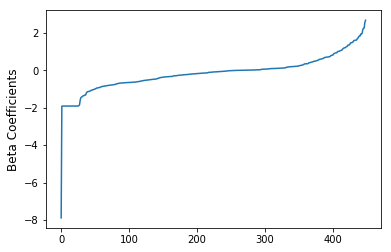

In [21]:
# if it does not run, try again and it will work

import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients
beta = np.sort(mod.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients', fontsize = 12)
plt.show()

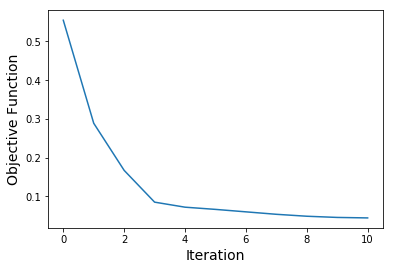

In [22]:
training_summary = mod.summary
objective_history = training_summary.objectiveHistory
plt.plot(objective_history)
plt.ylabel('Objective Function',fontsize=14)
plt.xlabel('Iteration',fontsize=14)
plt.show()

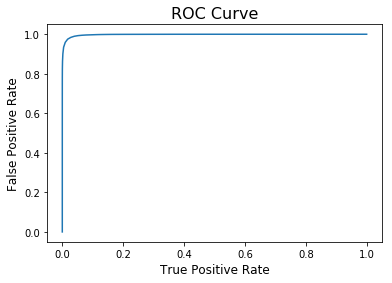

Training Area Under ROC: 0.99811145365966


In [23]:
# ROC curve
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate', fontsize = 12)
plt.xlabel('True Positive Rate',fontsize = 12)
plt.title('ROC Curve',size = 16)
plt.show()
print("Training Area Under ROC: " + str(training_summary.areaUnderROC))

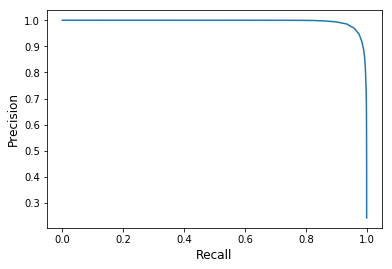

In [25]:
# Precision & Recall curve
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision', fontsize = 12)
plt.xlabel('Recall', fontsize = 12)
plt.show()

In [26]:
# Evaluate the model using the test data.
pred = mod.transform(test)
pred.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(449,[0,1,7,41,51...|[13.6709994114224...|[0.99999884452676...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[16.7602866423375...|[0.99999994738616...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[11.7547092585016...|[0.99999214780235...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[10.2174561108178...|[0.99996347423431...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[20.8783477977725...|[0.99999999914365...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[6.80386312135544...|[0.99889174878402...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[10.4090004989997...|[0.99996984110514...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[15.3075584040856...|[0.99999977508845...|       0.0|
|  0.0|(449,[0,1,7,41,51...|[13.2322233751555...|[0.99999820808408...|       0.0|
|  0.0|(449,[0,1

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC:', evaluator.evaluate(pred))

Test Area Under ROC: 0.9983196349060921
